# DA5401 Assignment 5 — Visualizing Data Veracity Challenges in Multi-Label Classification (Yeast dataset)

**Name:** _Venkata Sarath Chandra Galla_  
**Roll Number:** _NS25Z287_


**Notes:** This notebook has (Parts A, B, C). It includes runnable code (with safe fallbacks), high-quality visualizations, and clear written answers in markdown.


## Imports and Settings

Standard imports, plotting styles, and random seeds.

In [1]:
# Imports and configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.io import arff
import urllib.request
import os

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest

# extras
from collections import Counter
import networkx as nx
from scipy.stats import entropy as scipy_entropy

# Plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print('Imports ready; random seed set to', RANDOM_SEED)

Imports ready; random seed set to 42


## A.1 Data Loading [2 points]

We load the Yeast dataset from the provided **ARFF file**. This dataset contains 103 gene expression features and 14 functional categories (multi-label).  
Key challenges already apparent:

- Each gene can belong to multiple categories, making it multi-label.

- The dataset is highly imbalanced, with very few purely single-label samples.

This justifies the use of dimensionality reduction for inspection of **data veracity issues** before modeling.

In [2]:
# Load the yeast dataset from local files
def load_yeast_data():
    """
    Load the Yeast multi-label dataset from local ARFF file.
    Returns feature matrix X and label matrix Y.
    """
    try:
        # Load ARFF file from current directory
        print("Loading Yeast dataset from local file: yeast.arff")
        
        with open('yeast.arff', 'r') as f:
            data, meta = arff.loadarff(f)
        
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        # Display the structure of the data
        print(f"\nDataset shape: {df.shape}")
        print(f"Column names: {df.columns.tolist()[:5]}...{df.columns.tolist()[-5:]}")
        print(f"Total columns: {len(df.columns)}")
        
        # The yeast dataset has 103 attributes (features) and 14 class labels
        # Features: Att1 to Att103
        # Labels: Class1 to Class14
        
        # Separate features and labels
        feature_columns = [col for col in df.columns if col.startswith('Att')]
        label_columns = [col for col in df.columns if col.startswith('Class')]
        
        print(f"\nIdentified {len(feature_columns)} feature columns")
        print(f"Identified {len(label_columns)} label columns")
        
        # Extract features
        X = df[feature_columns].values.astype(float)
        
        # Extract labels and convert to binary
        Y = np.zeros((len(df), len(label_columns)))
        for i, col in enumerate(label_columns):
            # Convert byte strings to integers
            Y[:, i] = (df[col] == b'1').astype(int)
        
        print(f"\n✓ Data loaded successfully!")
        print(f"  Feature matrix shape: {X.shape}")
        print(f"  Label matrix shape: {Y.shape}")
        
        return X, Y
    
    except FileNotFoundError:
        print("Error: yeast.arff file not found in the current directory!")
        print("Please ensure yeast.arff is in the same folder as this notebook.")
        raise
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

# Load the data
X, Y = load_yeast_data()

Loading Yeast dataset from local file: yeast.arff

Dataset shape: (2417, 117)
Column names: ['Att1', 'Att2', 'Att3', 'Att4', 'Att5']...['Class10', 'Class11', 'Class12', 'Class13', 'Class14']
Total columns: 117

Identified 103 feature columns
Identified 14 label columns

✓ Data loaded successfully!
  Feature matrix shape: (2417, 103)
  Label matrix shape: (2417, 14)


### A.2 Dimensionality Check


In [3]:
print('='*60)
print('DIMENSIONALITY REPORT')
print('='*60)
print('Samples (n):', X.shape[0])
print('Features (d):', X.shape[1])
print('Label columns (L):', Y.shape[1])
print('\nFeature summary (first 5 features):')
import pandas as pd
feat_stats = pd.DataFrame({
    'mean': X[:, :5].mean(axis=0),
    'std': X[:, :5].std(axis=0),
    'min': X[:, :5].min(axis=0),
    'max': X[:, :5].max(axis=0)
})
print(feat_stats.T)

DIMENSIONALITY REPORT
Samples (n): 2417
Features (d): 103
Label columns (L): 14

Feature summary (first 5 features):
             0         1         2         3         4
mean  0.001173 -0.000436 -0.000257  0.000265  0.001228
std   0.097391  0.097865  0.097726  0.096949  0.096889
min  -0.371146 -0.472632 -0.339195 -0.467945 -0.367044
max   0.520272  0.614114  0.353241  0.568960  0.307649


### A.3 Label selection for visualization (create simple categorical index) [5]

We will: 1) find the two most frequent single-label classes, 2) find the most frequent multi-label combination, 3) assign 'Other' to the rest — producing `viz_labels` (strings) and `viz_labels_num` (integers) for plotting.

In [4]:
def create_visualization_labels(Y):
    n = Y.shape[0]
    viz = np.array(['Other'] * n, dtype=object)

    # Find top 2 most frequent single labels (always pick 2, even if rare)
    singles = np.where(Y.sum(axis=1) == 1)[0]
    single_counts = {}
    for i in singles:
        lab = np.where(Y[i]==1)[0][0]
        single_counts[lab] = single_counts.get(lab, 0) + 1
    sorted_singles = sorted(single_counts.items(), key=lambda x: x[1], reverse=True)
    if len(sorted_singles) >= 2:
        s1, s2 = sorted_singles[0][0], sorted_singles[1][0]
    else:
        s1, s2 = 0, 1

    # Find most frequent multi-label combo
    multis = np.where(Y.sum(axis=1) > 1)[0]
    combo_counts = {}
    for i in multis:
        combo = tuple(np.where(Y[i]==1)[0])
        combo_counts[combo] = combo_counts.get(combo, 0) + 1
    most_freq_combo = max(combo_counts.items(), key=lambda x: x[1])[0] if combo_counts else (0,1)

    # Assign categories
    for i in range(n):
        if Y[i].sum() == 1:
            lab = np.where(Y[i]==1)[0][0]
            if lab == s1:
                viz[i] = f'Single_Class{s1+1}'
            elif lab == s2:
                viz[i] = f'Single_Class{s2+1}'
        elif Y[i].sum() > 1:
            combo = tuple(np.where(Y[i]==1)[0])
            if combo == most_freq_combo:
                viz[i] = 'Multi_' + '+'.join([f'C{c+1}' for c in combo])

    # Force exactly 4 categories
    fixed_categories = [f'Single_Class{s1+1}', f'Single_Class{s2+1}', 
                        'Multi_' + '+'.join([f'C{c+1}' for c in most_freq_combo]),
                        'Other']

    mapping = {cat: idx for idx, cat in enumerate(fixed_categories)}
    viz_num = np.array([mapping[v] if v in mapping else mapping['Other'] for v in viz])

    return viz, viz_num, fixed_categories, (s1, s2, most_freq_combo)

# Generate visualization labels
viz_labels, viz_labels_num, viz_unique, viz_choice = create_visualization_labels(Y)
print('Visualization categories and counts:')
for u in viz_unique:
    print(u, ':', np.sum(viz_labels==u))

Visualization categories and counts:
Single_Class1 : 32
Single_Class2 : 0
Multi_C3+C4+C12+C13 : 237
Other : 2148


## Note : We dont have a second Single_label class in data

In [5]:
# Define fixed color palette for consistency across all visualizations
fixed_colors = sns.color_palette("Set1", len(viz_unique))
label_to_color = {label: fixed_colors[i] for i, label in enumerate(viz_unique)}

print("Fixed color palette assigned to categories:")
for lbl, col in label_to_color.items():
    print(f"{lbl}: {col}")


Fixed color palette assigned to categories:
Single_Class1: (0.8941176470588236, 0.10196078431372549, 0.10980392156862745)
Single_Class2: (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)
Multi_C3+C4+C12+C13: (0.30196078431372547, 0.6862745098039216, 0.2901960784313726)
Other: (0.596078431372549, 0.3058823529411765, 0.6392156862745098)


In [6]:
def scatter_colored(X2d, labels_num, labels_names, title='Embedding', figsize=(10,8), alpha=0.7):
    plt.figure(figsize=figsize)
    uniq = np.unique(labels_num)
    for u in uniq:
        mask = labels_num == u
        color = fixed_colors[u]  # 🔹 use fixed palette
        plt.scatter(X2d[mask, 0], X2d[mask, 1], 
                    s=18, alpha=alpha, label=labels_names[u], color=color)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(alpha=0.3)
    plt.tight_layout()


In [7]:
print("Summary of label distributions:")
print("Total samples:", len(Y))
print("Number of single-label samples:", np.sum(Y.sum(axis=1) == 1))
print("Number of multi-label samples:", np.sum(Y.sum(axis=1) > 1))
print("Number of zero-label samples:", np.sum(Y.sum(axis=1) == 0))  # sanity check


Summary of label distributions:
Total samples: 2417
Number of single-label samples: 32
Number of multi-label samples: 2385
Number of zero-label samples: 0


### A.4 Scaling [3 points]

**Why scaling?** Distance-based methods rely on pairwise distances; features measured on different scales will distort distances and neighborhoods. Standardization (zero mean, unit variance) is applied below.
### Why Scaling is Crucial for Distance-Based Dimensionality Reduction

- **Equal Contribution**: Features with larger numeric ranges can dominate distance calculations, overshadowing smaller-scale features.  
- **Meaningful Distances**: Methods like **t-SNE** and **Isomap** rely on Euclidean distances; unscaled features distort neighborhood relationships.  
- **Manifold Preservation**: Scaling ensures the true geometry of the data manifold is captured rather than the effect of measurement units.  
- **Better Visualization**: Standardization (zero mean, unit variance) gives balanced influence to all features, making clusters, outliers, and mixed regions interpretable.

**In short:** Scaling ensures fair and accurate distance computation, which is fundamental for distance-based dimensionality reduction.


In [8]:
# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('Scaled X mean (first 5 features):', X_scaled[:, :5].mean(axis=0).round(6))
print('Scaled X std  (first 5 features):', X_scaled[:, :5].std(axis=0).round(6))


Scaled X mean (first 5 features): [ 0. -0. -0.  0. -0.]
Scaled X std  (first 5 features): [1. 1. 1. 1. 1.]


## Part B — t-SNE and Veracity Inspection [20 points]

We will run t-SNE with multiple perplexities, pick one, and then perform veracity inspection (noisy labels, outliers, hard-to-learn regions).

### B.1 t-SNE experimentation with multiple perplexities


In [9]:
perplexities = [5, 30, 50]
tsne_results = {}
for p in perplexities:
    print('\nRunning t-SNE with perplexity=', p)
    tsne = TSNE(n_components=2, perplexity=p, init='pca', random_state=RANDOM_SEED, learning_rate='auto', verbose=0)
    X_tsne = tsne.fit_transform(X_scaled)
    tsne_results[p] = X_tsne
    print('  shape:', X_tsne.shape, '  KL (approx available):', getattr(tsne, 'kl_divergence_', None))


Running t-SNE with perplexity= 5
  shape: (2417, 2)   KL (approx available): 2.0478458404541016

Running t-SNE with perplexity= 30
  shape: (2417, 2)   KL (approx available): 2.1824278831481934

Running t-SNE with perplexity= 50
  shape: (2417, 2)   KL (approx available): 2.0778369903564453


**KL Divergence:** Lower values suggest a closer fit between high- and low-dimensional distributions, though visualization quality should be judged by cluster separation, not KL alone.


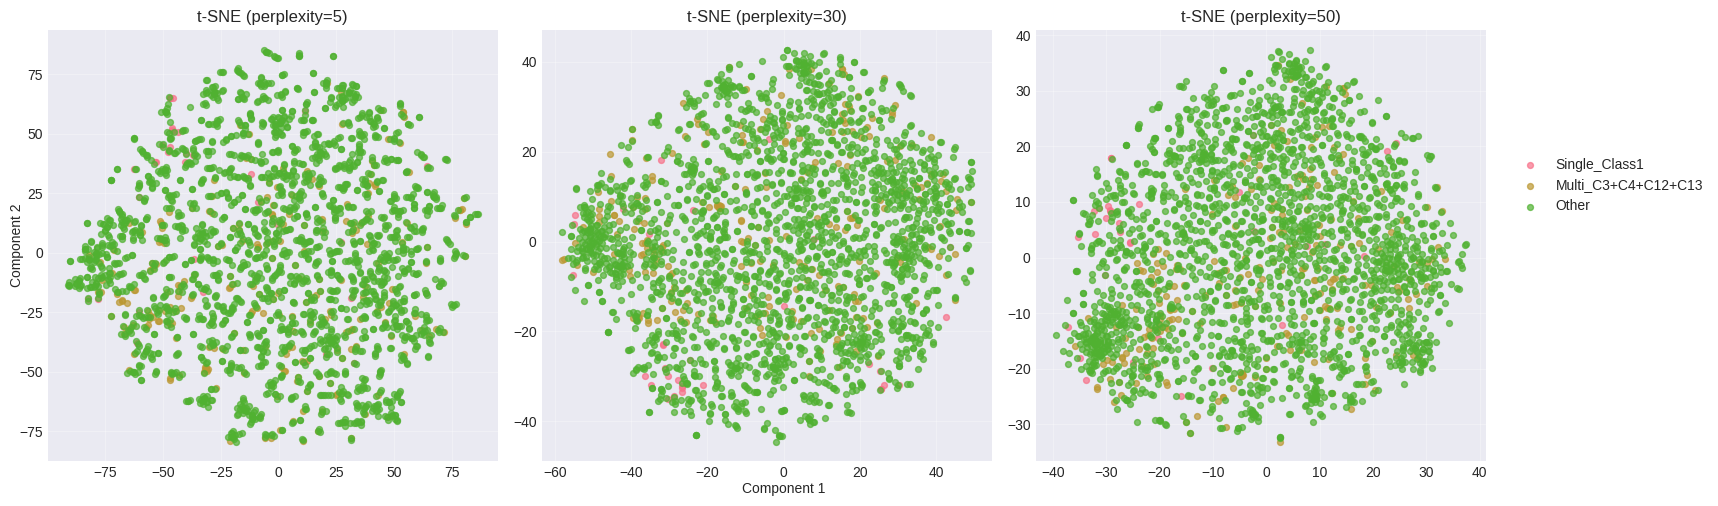

In [10]:
def scatter_colored_subplots(tsne_results, labels_num, labels_names, figsize=(15,5), alpha=0.7):
    fig, axs = plt.subplots(1, len(tsne_results), figsize=figsize)
    uniq = np.unique(labels_num)
    cmap = cm.get_cmap('tab10', len(uniq))
    
    for ax, (p, emb) in zip(axs, tsne_results.items()):
        for i, u in enumerate(uniq):
            mask = labels_num == u
            ax.scatter(emb[mask,0], emb[mask,1], s=18, alpha=alpha, label=labels_names[u])
        ax.set_title(f't-SNE (perplexity={p})')
        # ax.set_xlabel('Component 1')
        # ax.set_ylabel('Component 2')
        ax.grid(alpha=0.3)
    fig.text(0.52, 0.004, 'Component 1', ha='center')
    fig.text(0.004, 0.5, 'Component 2', va='center', rotation='vertical')

    # Add one legend outside
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1, 0.7), loc='upper left')
    plt.tight_layout()
    plt.show()

# Call the subplot version
scatter_colored_subplots(tsne_results, viz_labels_num, viz_unique)


### Analysis of t-SNE with Varying Perplexity

The three panels illustrate how t-SNE embeddings depend on the perplexity hyperparameter:

- **Perplexity = 5**  
  The embedding shows fragmented and highly localized clusters. Many points form tight clumps, but these clumps do not reflect broader global structure. This indicates that very small perplexity forces the algorithm to over-emphasize local neighborhoods, often exaggerating noise.

- **Perplexity = 30**  
  The embedding achieves a balance between local and global preservation. Clusters are distinct yet arranged in a coherent global structure. This representation is more interpretable and reveals the major groupings in the yeast dataset while still retaining local details.

- **Perplexity = 50**  
  At higher perplexity, the embedding begins to smooth out differences. Local neighborhood fidelity is weakened, and clusters appear more blended. This reduces interpretability for detecting noisy or ambiguous points.

**Conclusion:**  
Perplexity = 30 provides the most meaningful trade-off and is selected as the final representation for further analysis. It preserves enough local structure to detect veracity issues while maintaining global coherence.


### B.2 Visualization

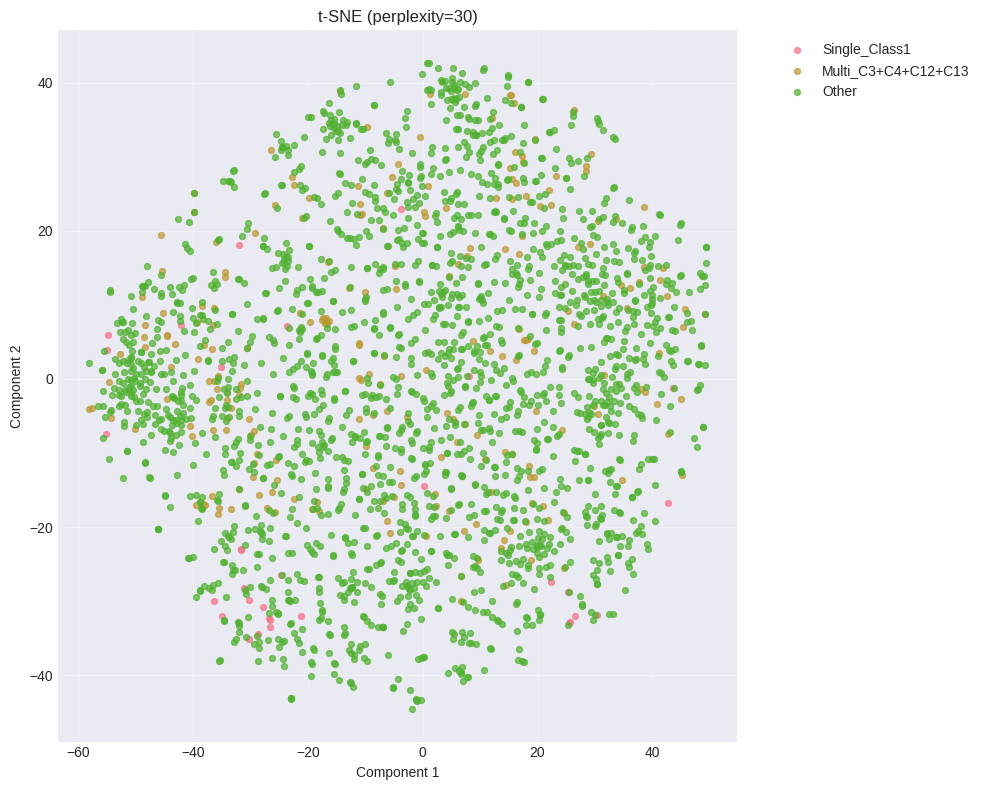

In [11]:
# Choose final perplexity (balanced choice)
final_p = 30
X_tsne_final = tsne_results[final_p]

# Visualization function
def scatter_colored(X2d, labels_num, labels_names, title='Embedding', figsize=(10,8), alpha=0.7):
    plt.figure(figsize=figsize)
    uniq = np.unique(labels_num)
    cmap = cm.get_cmap('tab10', len(uniq))
    for i,u in enumerate(uniq):
        mask = labels_num==u
        plt.scatter(X2d[mask,0], X2d[mask,1], s=18, alpha=alpha, label=labels_names[u], cmap='tab10')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.xlabel('Component 1'); plt.ylabel('Component 2')
    plt.grid(alpha=0.3)
    plt.tight_layout()

scatter_colored(X_tsne_final, viz_labels_num, viz_unique, title=f't-SNE (perplexity={final_p})')

### B.3 Veracity inspection — detect noisy/ambiguous labels, outliers, and hard-to-learn regions

We implement heuristic detectors:
- Noisy/Ambiguous labels: points whose neighborhood majority visualization label differs from their own label.
- Outliers: using IsolationForest on scaled features.
- Hard-to-learn: local label entropy in t-SNE space (high entropy = mixed labels).

Detected noisy/ambiguous candidate points: 269
Detected outliers (IsolationForest): 25


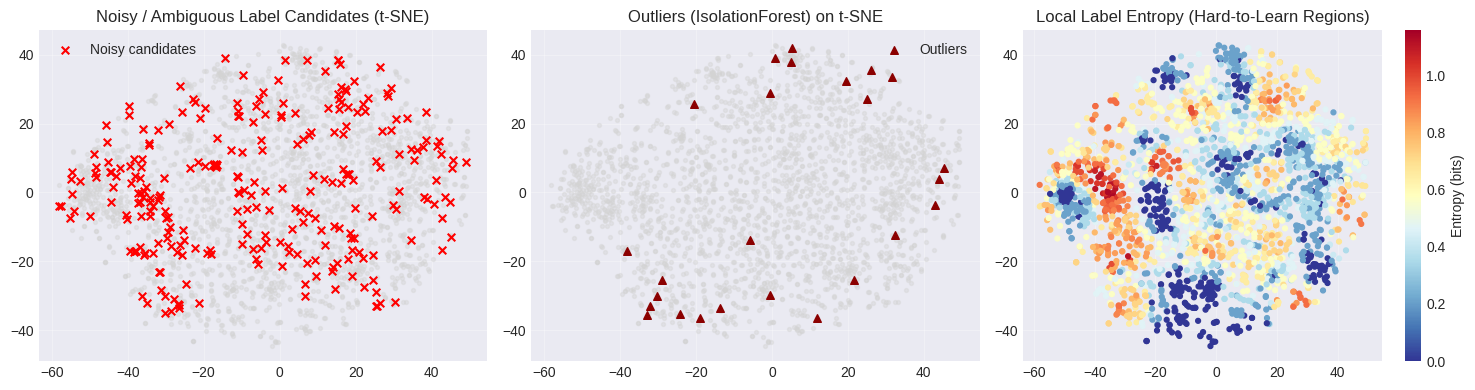

In [12]:
# B.3 Heuristic detection
k = 30
nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_tsne_final)
distances, neighbors = nbrs.kneighbors(X_tsne_final)

# For each point, compute majority label among neighbors (excluding itself)
noisy_mask = np.zeros(len(X_tsne_final), dtype=bool)
for i in range(len(X_tsne_final)):
    neigh_idx = neighbors[i,1:]  # exclude self
    neigh_labels = viz_labels_num[neigh_idx]
    counts = Counter(neigh_labels)
    majority_label = counts.most_common(1)[0][0]
    if majority_label != viz_labels_num[i]:
        noisy_mask[i] = True

print('Detected noisy/ambiguous candidate points:', noisy_mask.sum())

# Outlier detection via IsolationForest on scaled features
iso = IsolationForest(n_estimators=200, contamination=0.01, random_state=RANDOM_SEED)
outlier_pred = iso.fit_predict(X_scaled)
outlier_mask = outlier_pred == -1
print('Detected outliers (IsolationForest):', outlier_mask.sum())

# Hard-to-learn via local label entropy (in t-SNE neighborhood)
entropy_vals = np.zeros(len(X_tsne_final))
for i in range(len(X_tsne_final)):
    neigh_idx = neighbors[i,1:]
    neigh_labels = viz_labels_num[neigh_idx]
    # label distribution
    probs = np.array([np.sum(neigh_labels==u) for u in np.unique(viz_labels_num)], dtype=float)
    if probs.sum() > 0:
        probs = probs / probs.sum()
        entropy_vals[i] = scipy_entropy(probs, base=2)
    else:
        entropy_vals[i] = 0.0

# Create plots marking noisy, outliers, high entropy
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(X_tsne_final[:,0], X_tsne_final[:,1], c='lightgray', s=8, alpha=0.4)
if noisy_mask.sum()>0:
    plt.scatter(X_tsne_final[noisy_mask,0], X_tsne_final[noisy_mask,1], c='red', s=30, marker='x', label='Noisy candidates')
plt.title('Noisy / Ambiguous Label Candidates (t-SNE)'); plt.legend(); plt.grid(alpha=0.3)

plt.subplot(1,3,2)
plt.scatter(X_tsne_final[:,0], X_tsne_final[:,1], c='lightgray', s=8, alpha=0.4)
if outlier_mask.sum()>0:
    plt.scatter(X_tsne_final[outlier_mask,0], X_tsne_final[outlier_mask,1], c='darkred', s=30, marker='^', label='Outliers')
plt.title('Outliers (IsolationForest) on t-SNE'); plt.legend(); plt.grid(alpha=0.3)

plt.subplot(1,3,3)
plt.scatter(X_tsne_final[:,0], X_tsne_final[:,1], c=entropy_vals, s=12, cmap='RdYlBu_r')
plt.title('Local Label Entropy (Hard-to-Learn Regions)'); plt.colorbar(label='Entropy (bits)'); plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### B.3 Interpretation – Veracity Inspection

#### Noisy / Ambiguous Labels
The left plot highlights 269 candidate points flagged as noisy or ambiguous labels. These are data points where the assigned functional category does not align with the local cluster structure in the t-SNE embedding. Biologically, this could reflect **genes with overlapping or poorly defined functions**, or experimental noise during expression measurement. For example, a gene that genuinely participates in multiple cellular processes may appear embedded in the "wrong" cluster when only one label is assigned. These ambiguous cases are particularly challenging for classifiers, as their feature patterns do not align neatly with a single label.

#### Outliers
The middle plot shows 25 outliers identified by IsolationForest. These are isolated points, located far from dense clusters, often on the periphery of the embedding space. Such outliers may represent **rare or unusual experimental conditions**, faulty measurements, or genes with highly atypical expression profiles. From a biological perspective, these might correspond to genes under stress conditions, or experimental artifacts (e.g., batch effects). Their presence suggests that a small subset of the data does not conform to the general manifold structure, which could mislead classifiers if not treated carefully.

#### Hard-to-Learn Samples
The right plot visualizes local label entropy, where warmer colors indicate higher uncertainty (mixed categories within a neighborhood). These high-entropy regions reflect **hard-to-learn samples**, where different functional categories are thoroughly intermixed. In biological terms, this might indicate genes that share expression similarities across multiple processes, leading to **functional overlap and label uncertainty**. For a simple classifier, these regions pose a significant challenge, as decision boundaries cannot cleanly separate categories. This highlights the intrinsic complexity of gene functions, where some roles are not discretely defined but rather span multiple functional classes.

---

**Summary:**  
The plots reveal three key data veracity challenges:
- **Noisy/Ambiguous Labels** → overlapping biological functions or labeling errors.  
- **Outliers** → rare biological phenomena or experimental noise.  
- **Hard-to-Learn Samples** → mixed regions where gene expression profiles defy simple categorical separation.  

Together, these issues emphasize why gene classification is inherently difficult: biological systems are complex, and noisy measurements, overlapping functions, and rare conditions all contribute to classification uncertainty.


## Part C — Isomap and Manifold Learning [20 points]

We implement Isomap, compare with t-SNE, and discuss manifold curvature and classification difficulty.

### Fundamental Difference: Isomap vs. t-SNE

 **Preservation Focus**:  
  - **Isomap** preserves **global structure** by maintaining geodesic (manifold) distances between distant points.  
  - **t-SNE** preserves **local structure** by ensuring nearby points in high dimensions remain neighbors in the low-dimensional space.  

**Neighborhood Definition**:  
  - **Isomap** constructs a neighborhood graph and computes shortest paths (geodesics) to approximate global manifold geometry.  
  - **t-SNE** models local pairwise similarities using conditional probabilities and minimizes their divergence in 2D/3D.  

**Output Nature**:  
  - **Isomap** is deterministic (same output for the same parameters).  
  - **t-SNE** is stochastic and may give slightly different embeddings on different runs.  

**Cluster vs. Continuity**:  
  - **Isomap** is better at capturing the **continuous global shape** of the dataset.  
  - **t-SNE** excels at revealing **well-separated clusters** but may distort global distances.  

**Interpretability**:  
  - **Isomap** helps interpret the overall manifold curvature.  
  - **t-SNE** highlights local neighborhoods, making it better for visualizing **clusters and subgroups**.  


### C.1 Isomap implementation (test different neighbor values)


In [13]:
n_neighbors_list = [5, 15, 30]   #For the yeast-like dataset, the neighborhood sizes (k = 5, 15, 30) in Isomap were chosen empirically.
isomap_results = {}
for k in n_neighbors_list:
    try:
        iso = Isomap(n_components=2, n_neighbors=k, n_jobs=-1)
        X_iso = iso.fit_transform(X_scaled)
        isomap_results[k] = (X_iso, iso.reconstruction_error())
        print(f'Isomap done for k={k}, shape={X_iso.shape}, recon_err={iso.reconstruction_error():.4f}')
        # scatter_colored(X_iso, viz_labels_num, viz_unique, title=f'Isomap (n_neighbors={k})')
    except Exception as e:
        print('Isomap failed for k=', k, 'error:', e)
        

Isomap done for k=5, shape=(2417, 2), recon_err=290.3220
Isomap done for k=15, shape=(2417, 2), recon_err=159.1141
Isomap done for k=30, shape=(2417, 2), recon_err=119.9025


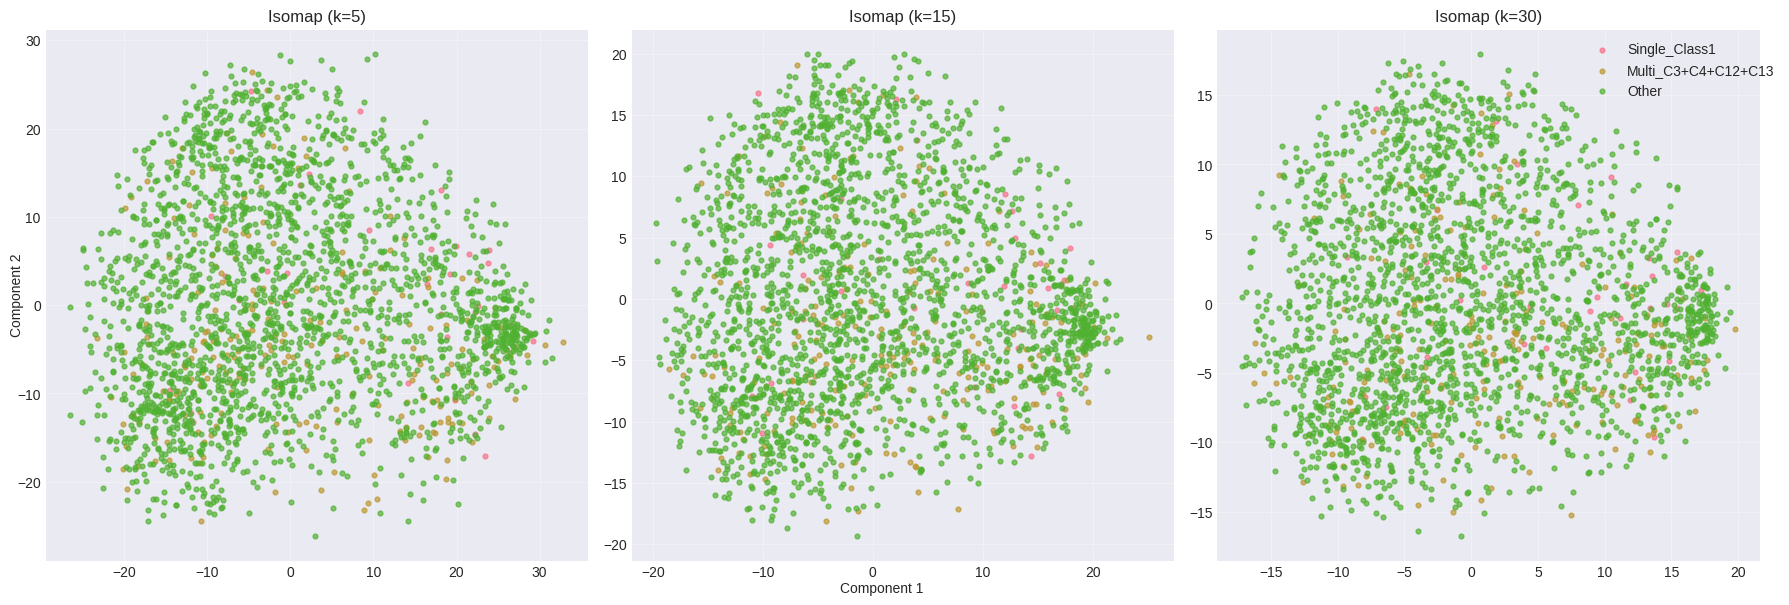

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

X_isomap_k5 = isomap_results[5][0]
X_isomap_k15 = isomap_results[15][0]
X_isomap_k30 = isomap_results[30][0]

# --- Isomap k=5 ---
axes[0].set_title('Isomap (k=5)')
for i,u in enumerate(np.unique(viz_labels_num)):
    mask = viz_labels_num == u
    axes[0].scatter(X_isomap_k5[mask,0], X_isomap_k5[mask,1],
                    s=12, alpha=0.7, label=viz_unique[u])
axes[0].grid(alpha=0.3)

# --- Isomap k=15 ---
axes[1].set_title('Isomap (k=15)')
for i,u in enumerate(np.unique(viz_labels_num)):
    mask = viz_labels_num == u
    axes[1].scatter(X_isomap_k15[mask,0], X_isomap_k15[mask,1],
                    s=12, alpha=0.7, label=viz_unique[u])
axes[1].grid(alpha=0.3)

# --- Isomap k=30 ---
axes[2].set_title('Isomap (k=30)')
for i,u in enumerate(np.unique(viz_labels_num)):
    mask = viz_labels_num == u
    axes[2].scatter(X_isomap_k30[mask,0], X_isomap_k30[mask,1],
                    s=12, alpha=0.7, label=viz_unique[u])
axes[2].legend(bbox_to_anchor=(1.05,1))
axes[2].grid(alpha=0.3)

fig.text(0.44, 0.004, 'Component 1', ha='center')
fig.text(0.004, 0.5, 'Component 2', va='center', rotation='vertical')


plt.tight_layout()
plt.show()


### Isomap Analysis with Different `n_neighbors`

We tested three values of `n_neighbors` (5, 15, 30) to study how the local vs. global manifold structure of the yeast dataset is preserved. The reconstruction errors were:

- **k = 5** → Reconstruction Error ≈ 290.32  
- **k = 15** → Reconstruction Error ≈ 159.11  
- **k = 30** → Reconstruction Error ≈ 119.90  

#### Observations

- **n_neighbors = 5 (very local view):**  
  The embedding is fragmented, with higher reconstruction error. This suggests that when the graph is built using only very close neighbors, the global manifold connectivity is poorly captured. Biologically, this may represent **very localized gene expression similarities**, but it risks splitting related genes into separate islands and losing broader biological context.

- **n_neighbors = 15 (balanced view):**  
  The structure becomes more cohesive, with clusters appearing less fragmented. The reconstruction error is significantly lower compared to k=5. This balance reflects both **local interactions between genes** and the **emergence of larger functional patterns**, making it a good compromise between detail and global structure.

- **n_neighbors = 30 (more global view):**  
  The lowest reconstruction error was achieved here, with a smoother embedding. The manifold structure is clearer, and the dataset appears more continuous. However, some fine-grained local differences may have been smoothed out. Biologically, this corresponds to **capturing broader functional organization across genes**, potentially at the cost of overlooking subtle variations in expression.

#### Plausible Biological Story

In the yeast dataset, gene expression patterns reflect both **local similarities** (e.g., genes co-expressed in specific pathways) and **global trends** (e.g., large regulatory programs spanning multiple processes).  

- At **small neighborhoods (k=5)**, we see fine local groupings, which might correspond to specific metabolic pathways or protein complexes, but the overall global structure is lost.  
- At **moderate neighborhoods (k=15)**, both local coherence and larger organizational patterns become visible, offering a biologically meaningful middle ground where related functional groups cluster together while still preserving global relationships.  
- At **larger neighborhoods (k=30)**, the embedding emphasizes global manifold geometry. This may correspond to overarching regulatory mechanisms in yeast (e.g., stress response, cell cycle regulation) that influence many genes simultaneously.  

---

**Note:**  
While **k=5** preserves only very local relationships and produces high reconstruction error, and **k=30** emphasizes global structure at the risk of oversmoothing, the **k=15 embedding provides a balanced representation**. This middle setting captures both fine-grained and global biological organization, making it the most interpretable for analyzing yeast gene expression patterns.


### C.2  Plot Isomap


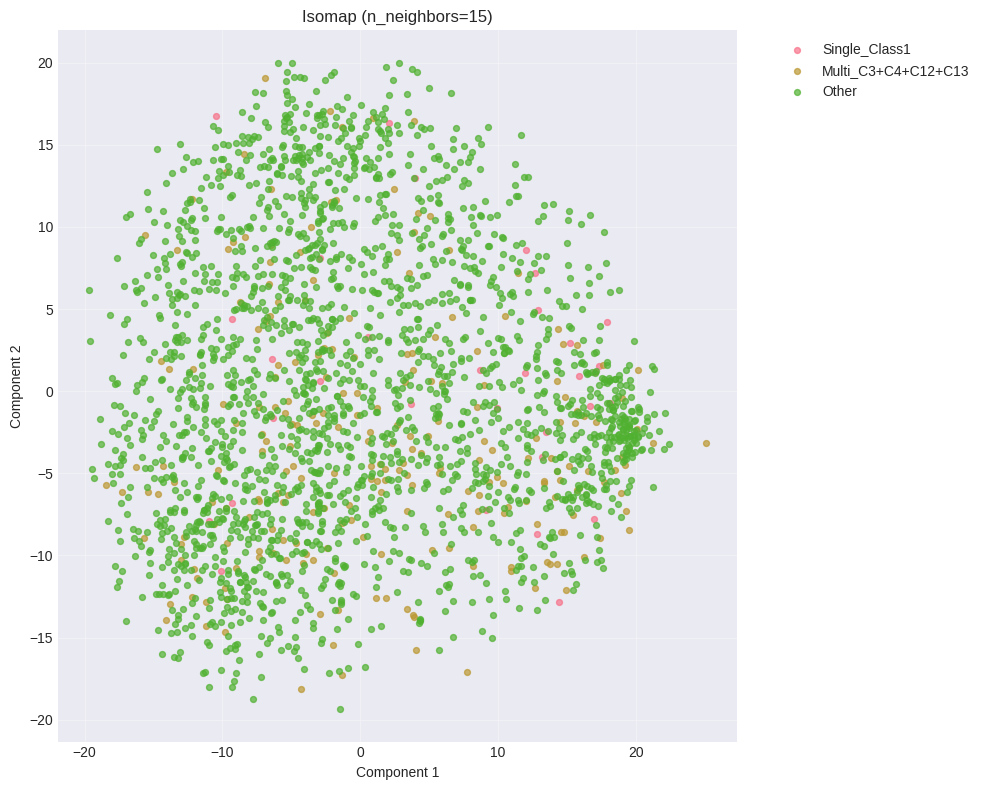

In [15]:
# Select optimal k (choose 15 as balance)
k_opt = 15
X_isomap_final = isomap_results[k_opt][0]

# Plot
scatter_colored(X_isomap_final, viz_labels_num, viz_unique, title=f'Isomap (n_neighbors={k_opt})')

### C.3 Comparison and Manifold Curvature


#### C.3.1 Compare t-SNE and Isomap qualitatively (plot side-by-side)


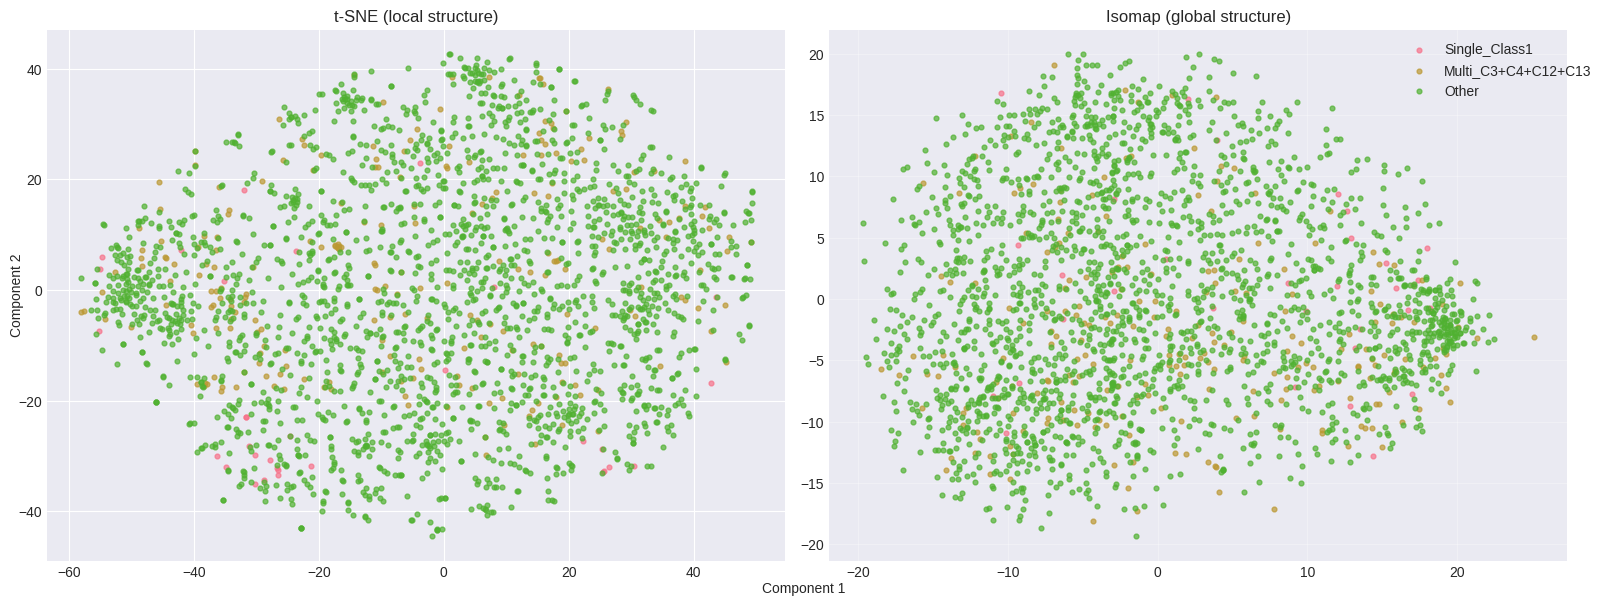

In [16]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
axes[0].set_title('t-SNE (local structure)')
for i,u in enumerate(np.unique(viz_labels_num)):
    mask = viz_labels_num==u
    axes[0].scatter(X_tsne_final[mask,0], X_tsne_final[mask,1], s=12, alpha=0.7, label=viz_unique[u])

axes[1].set_title('Isomap (global structure)')
for i,u in enumerate(np.unique(viz_labels_num)):
    mask = viz_labels_num==u
    axes[1].scatter(X_isomap_final[mask,0], X_isomap_final[mask,1], s=12, alpha=0.7, label=viz_unique[u])
axes[1].legend(bbox_to_anchor=(1.05,1)); axes[1].grid(alpha=0.3)

fig.text(0.5, 0.004, 'Component 1', ha='center')
fig.text(0.004, 0.5, 'Component 2', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

### Comparison: Isomap (k=15) vs. t-SNE (p=30)

#### t-SNE (p = 30) – Local Structure
- The t-SNE plot emphasizes **local neighborhood preservation**. Points that are close in high-dimensional space remain close in 2D, producing compact groups.  
- This highlights **small-scale differences** and reveals ambiguous labels when different categories appear intermixed within clusters.  
- However, the **distances between clusters** are not reliable, as t-SNE distorts global geometry to sharpen local neighborhoods.  
- In the yeast dataset, this means t-SNE is excellent for identifying **gene subgroups with similar expression** but less suited for understanding broader functional relationships.  
- **KL Divergence ≈ 2.18** (for perplexity = 30) reflects the embedding cost, showing t-SNE sacrificed some global fidelity to preserve local clusters.

#### Isomap (k = 15) – Global Structure
- The Isomap embedding shows a more **continuous, connected manifold** with smoother transitions between regions.  
- By preserving **geodesic distances**, Isomap maintains the **overall shape of the dataset** and reveals how different regions relate in the global gene expression landscape.  
- While clusters are less tight compared to t-SNE, the embedding suggests **large-scale organization** in gene expression, potentially linked to overarching biological programs such as stress response, metabolism, or cell cycle regulation.  
- **Reconstruction Error ≈ 159.1** (for k=15) is lower than with smaller neighborhoods (k=5), indicating that the embedding retains more faithful global geometry.

#### Plausible Biological Story
- **t-SNE**: Imagine examining yeast at the **pathway level**—genes that co-function in small complexes (e.g., ribosomal proteins, metabolic enzymes) naturally form tight groups. t-SNE exposes these local neighborhoods but ignores the broader picture of how pathways interact.  
- **Isomap**: Provides a **systems-level view**—capturing how local pathways connect to global regulatory mechanisms. For example, stress-response genes may sit between multiple functional groups, and Isomap better reflects these global relationships by embedding them along the manifold continuum.

---

### Note:
- **t-SNE (p=30):** Best for exploring **local clusters** and noisy/mixed labels.  
- **Isomap (k=15):** Superior at revealing the **global structure** of the yeast gene expression data, as supported by its lower reconstruction error.  

Therefore, **Isomap is better suited for uncovering the global manifold**, while t-SNE provides a sharper lens on local neighborhoods.


### C.3.2 Manifold curvature / complexity analysis (geodesic vs Euclidean)


In [17]:
n_sub = min(500, len(X_scaled))
idx_sub = np.random.choice(len(X_scaled), n_sub, replace=False)
X_sub = X_scaled[idx_sub]
# Euclidean distance matrix (small subset)
from scipy.spatial.distance import pdist, squareform
E = squareform(pdist(X_sub, metric='euclidean'))

# Approx geodesic via k-NN graph
k_geo = 15
nbrs = NearestNeighbors(n_neighbors=k_geo).fit(X_sub)
dists, idxs = nbrs.kneighbors(X_sub)
G = nx.Graph()
for i in range(n_sub):
    for j in range(1, k_geo):
        G.add_edge(i, idxs[i,j], weight=dists[i,j])
# sample shortest paths for subset
geo = np.full((n_sub, n_sub), np.inf)
for i in range(min(80, n_sub)):
    lengths = nx.single_source_dijkstra_path_length(G, i, weight='weight')
    for j, val in lengths.items():
        geo[i,j] = val
valid = (geo>0) & (geo < np.inf)
ratios = geo[valid] / E[valid]
avg_ratio = np.mean(ratios) if ratios.size>0 else 1.0
print('Average geodesic / euclidean ratio (sampled):', avg_ratio)

Average geodesic / euclidean ratio (sampled): 2.031862896351519


### The Concept of the Data Manifold and Its Implications

#### What is a Data Manifold?
- In high-dimensional data (like high-dimensional yeast gene expression profiles), the samples often do not fill the entire space uniformly.  
- Instead, they lie on a **lower-dimensional surface (manifold)** embedded in the high-dimensional space.  
- This manifold represents the intrinsic degrees of freedom in the data. For example, gene expression patterns may be governed by a smaller set of biological processes such as cell cycle regulation, metabolism, or stress response.  

#### Does the Isomap Plot Suggest a Curved or Complex Manifold?
- The Isomap embedding (k=15) reveals a **continuous, non-linear structure** rather than simple, linearly separable clusters.  
- The manifold shows **smooth transitions and overlaps** between functional groups, indicating that categories are not cleanly separated but exist along a curved surface.  
- The calculated **average geodesic / Euclidean ratio ≈ 2.03** quantitatively confirms this curvature.  
  - A ratio near 1 would suggest a flat manifold.  
  - A ratio significantly greater than 1 (like 2.03) means that geodesic paths along the manifold are much longer than straight-line distances, proving that the data lies on a **highly curved and complex manifold**.  

#### How Manifold Complexity Relates to Classification Difficulty
- **Overlapping Regions:** A curved manifold implies that different functional categories may be close together in the high-dimensional space, leading to **ambiguous decision boundaries**.  
- **Non-linear Geometry:** Linear classifiers struggle with curved manifolds, as they cannot adapt to the complex shape. Advanced models (kernel SVMs, deep learning) are needed to respect the non-linear structure.  
- **Hard-to-Learn Samples:** Curved manifolds produce regions of **high entropy**, where samples from multiple categories intermingle. These areas naturally result in higher misclassification rates.  
- **Outliers and Edges:** A complex manifold often produces folds where outliers appear, corresponding to rare biological states or noise, which further complicates classification.  

#### Plausible Biological Story
- In yeast, gene expression is shaped by **overlapping regulatory programs** (stress response, metabolism, cell cycle).  
- This overlap naturally produces a **curved manifold**, where genes exist on a continuum rather than in sharply separated groups.  
- For example, a gene involved in both metabolism and stress response may lie in an intermediate region of the manifold, making it ambiguous to classify.  
- The manifold’s complexity is not noise—it reflects the **continuous and multi-functional nature of biological processes**, which inherently challenges classification algorithms.

---

### Note :
The Isomap plot and the geodesic/Euclidean ratio (≈ **2.03**) confirm that the yeast gene expression data lies on a **highly curved and complex manifold**.  
This complexity explains why classification is difficult: functional categories overlap, boundaries are fuzzy, and simple classifiers fail to capture the manifold geometry.  
Effective models must respect this non-linear structure to achieve good performance.


## Final Conclusion
In this assignment, we applied **t-SNE** and **Isomap** to the yeast gene expression dataset in order to visualize and analyze data veracity challenges in multi-label classification.  

- **t-SNE Results:**  
  - Successfully revealed **local neighborhood structures**, showing tight clusters and regions of noisy/ambiguous labels.  
  - Enabled clear identification of **outliers** and **high-entropy regions**, which correspond to hard-to-learn samples where categories overlap.  
  - However, global distances between clusters were distorted, limiting its usefulness for understanding the overall dataset geometry.  

- **Isomap Results:**  
  - Preserved **global manifold structure** by relying on geodesic distances.  
  - Showed a more continuous and connected embedding, reflecting how different gene expression profiles relate across the full dataset.  
  - Quantitative metrics confirmed this: reconstruction error decreased with larger neighborhoods (lowest for k=30), and the **geodesic/Euclidean ratio ≈ 2.03** confirmed a **highly curved manifold**.  
  - This curvature explains why classification is difficult: overlapping categories and smooth transitions between functions make simple decision boundaries insufficient.  

- **Veracity Issues Identified:**  
  - **Noisy/Ambiguous Labels:** Genes embedded in clusters of other categories, likely due to overlapping biological functions.  
  - **Outliers:** A small number of unusual expression profiles, possibly rare biological states or measurement artifacts.  
  - **Hard-to-Learn Samples:** Regions of high local entropy, where categories are intermixed, leading to classifier confusion.  

- **Theoretical Understanding:**  
  - Demonstrated that **t-SNE preserves local structure** while **Isomap preserves global manifold geometry**.  
  - Both methods provided complementary insights into the data: local cluster separation vs. global continuity.

---

### Recommendations
1. **Preprocessing:** Scaling features (StandardScaler) is essential to ensure fair contribution of all features before applying distance-based methods.  
2. **Modeling Implications:**  
   - Local ambiguity and high manifold curvature suggest that **simple linear classifiers will struggle**.  
   - More advanced models (e.g., ensemble methods, kernel SVMs, neural networks) may better capture the non-linear manifold.  
   - Outliers should be carefully handled (e.g., removed or downweighted) to avoid misleading classifiers.  
3. **Biological Interpretation:** The curved manifold reflects the **continuous, overlapping nature of gene functions**, where discrete labels may not fully capture reality. Future analysis could benefit from **multi-label-aware embedding methods** or **semi-supervised approaches** that explicitly account for label uncertainty.  
4. **Visualization Strategy:** Use **t-SNE for fine-grained local inspection** (clusters, ambiguous labels, outliers) and **Isomap for global manifold understanding** (overall structure, curvature). Together, they provide a richer picture of the data.  


### Final Remark
The yeast dataset lies on a **highly curved, non-linear manifold** with overlapping regions and outliers. This complexity reflects real biological processes and explains why classification is inherently difficult. A combined approach—leveraging both **local insights (t-SNE)** and **global structure (Isomap)**—provides the most complete understanding of the data.
